# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [161]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread
from zipfile import ZipFile

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [162]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is present in both notebooks

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [163]:
### load processed data

if load_full:
    data_zipfile = zipfile.ZipFile(processed_data_train_file + ".zip")
    data = pd.read_json(data_zipfile.open(data_zipfile.namelist()[0], 'r'))
else: # not load_full
    data = pd.read_json(processed_data_train_file)

data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [164]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

## Step 2: Explore Data

In [165]:
image_counter = 0

In [166]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [167]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (17926, 32)



In [168]:
# display top rows of data set
print
data.head()

,address_state,annual_income,cpi,delinq_2_yrs,desc_len,description,dti,earliest_credit,employ_length,employ_title,gdp,home_owner,index,initial_list_status,inquiry_6_mos,installment,interest_rate,ipr,issue_date,loan_amount,loan_purpose,loan_status,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
1,TX,"100,000",0,0,94,Borrower added on _number_/_number_/_number_...,0,1993-11-01,0,Schwan's,1,MORTGAGE,191183,f,0,136,10,0,Oct-2012,4200,other,False,8,36,nan,7,0,0,0,20,0,nan
10,NY,"62,000",0,0,123,Borrower added on _number_/_number_/_number_...,0,1995-07-01,10,R Marcil Associates,1,MORTGAGE,194814,f,1,865,18,0,Oct-2012,24000,debt_consolidation,False,18,36,nan,16,0,0,0,34,0,nan
100,SC,"32,000",0,0,156,Borrower added on _number_/_number_/_number_...,0,1997-05-01,1,Palmetto Corp,1,RENT,197006,f,1,89,17,0,Oct-2012,2500,major_purchase,False,13,36,114,8,0,0,0,9,0,nan
1000,NJ,"220,000",0,0,86,Borrower added on _number_/_number_/_number_...,0,2001-08-01,7,Secova,1,OWN,183951,f,1,607,13,0,Dec-2012,18000,debt_consolidation,False,8,36,nan,9,0,0,0,43,0,nan
10001,CA,"52,000",0,0,nan,None,0,1994-02-01,1,Brokerage Assistant,1,MORTGAGE,426497,f,0,383,15,0,Mar-2014,16000,debt_consolidation,False,13,60,nan,14,0,0,0,33,0,nan


In [169]:
# summarize data set
print
data.describe()

,annual_income,cpi,delinq_2_yrs,desc_len,dti,gdp,index,inquiry_6_mos,installment,interest_rate,ipr,loan_amount,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
count,"17,926","17,926","17,926","6,241","17,926","17,926","17,926","17,926","17,926","17,926","17,926","17,926","17,926","17,926","2,155","17,926","17,926","17,926","17,926","17,926","17,926",0
mean,"72,998",0,0,295,0,1,"255,114",1,420,14,0,"13,618",12,41,78,11,155,0,0,25,0,nan
std,"49,543",0,1,329,0,0,"218,543",1,245,4,0,"8,147",7,10,28,5,730,0,0,12,0,nan
min,"4,000",0,0,1,0,1,36,0,23,5,0,725,3,36,0,1,0,0,0,2,0,nan
25%,"45,000",0,0,nan,0,1,"98,423",0,241,11,0,"7,500",8,36,nan,7,0,0,0,16,0,nan
50%,"62,027",0,0,nan,0,1,"196,835",1,367,13,0,"12,000",13,36,nan,10,0,0,0,23,0,nan
75%,"88,000",0,0,nan,0,1,"365,742",1,549,17,0,"18,250",18,36,nan,13,0,0,0,32,0,nan
max,"1,900,000",0,2,"5,016",0,1,"887,371",3,"1,407",28,0,"35,000",33,60,119,76,"18,174",0,0,99,0,nan


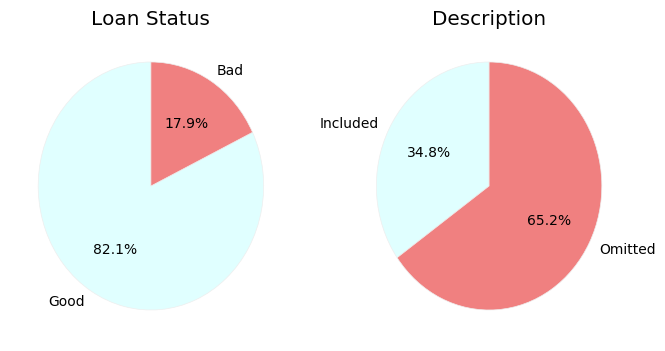

In [170]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

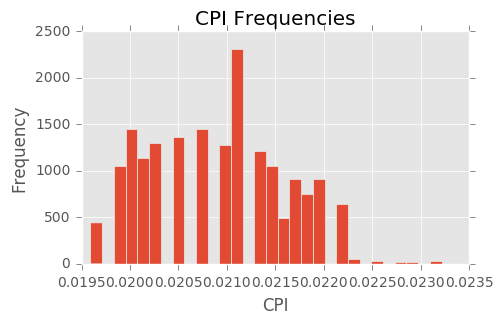

In [171]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

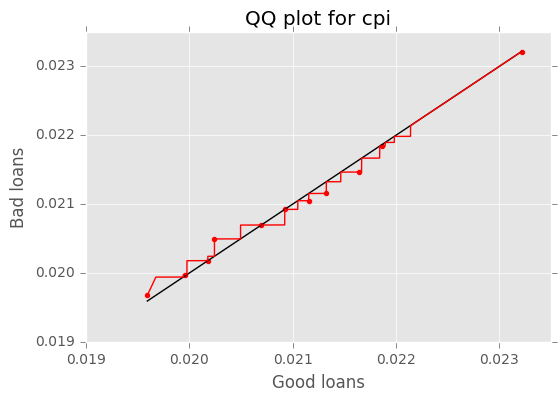

In [172]:
good_bad_quantile_plot(data, 'cpi')

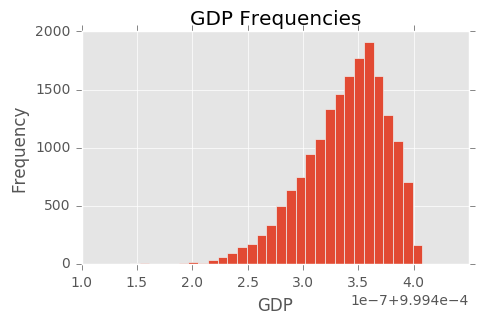

In [173]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

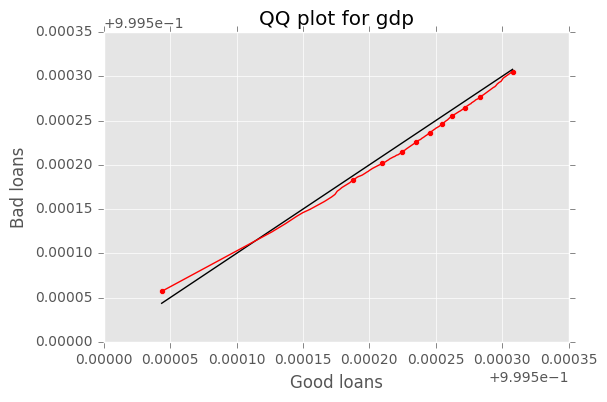

In [174]:
good_bad_quantile_plot(data, 'gdp')

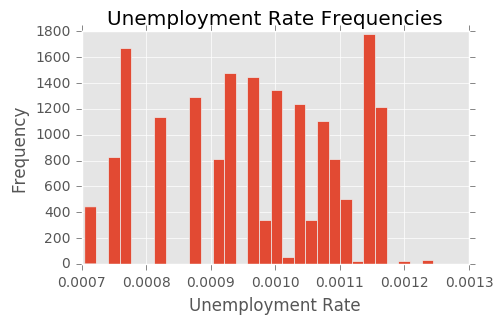

In [175]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

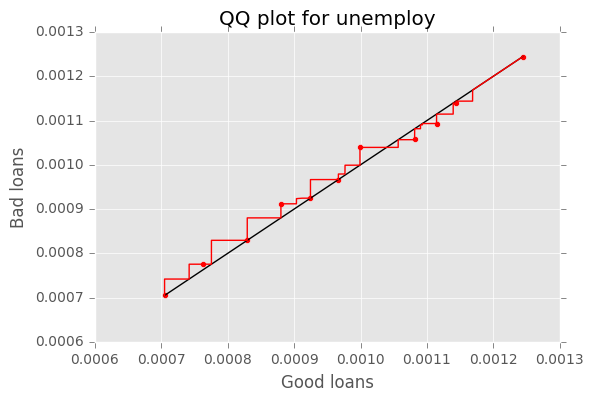

In [176]:
good_bad_quantile_plot(data, 'unemploy')

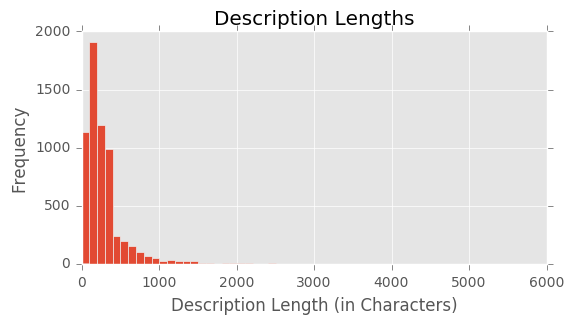

In [177]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
description_lengths = data['desc_len'][description_flags]

ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

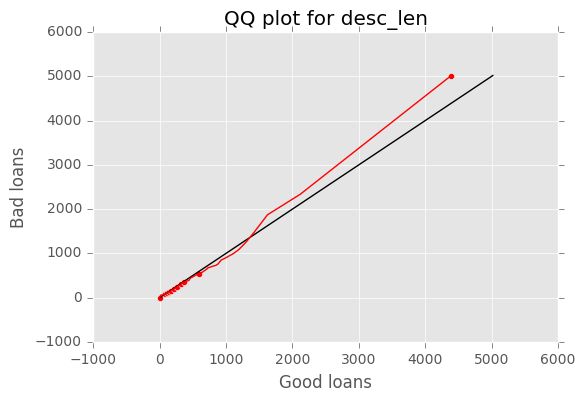

In [178]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [179]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,"6,241"
mean,295
std,329
min,1
25%,120
50%,208
75%,343
max,"5,016"


In [180]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.         -0.00962278]
 [-0.00962278  1.        ]]



### Text Analysis

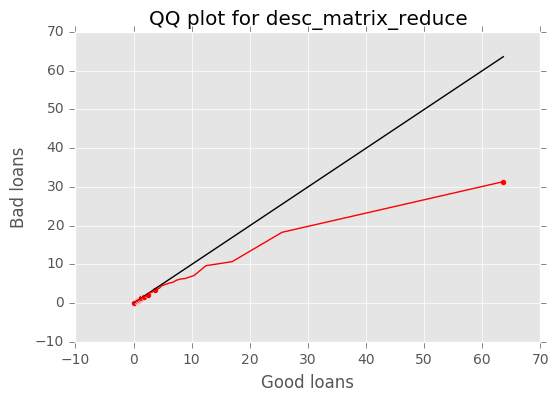

In [181]:
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

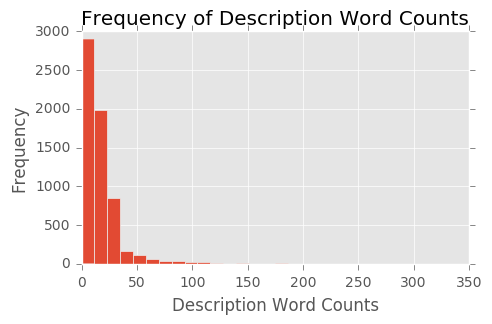

In [182]:
# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

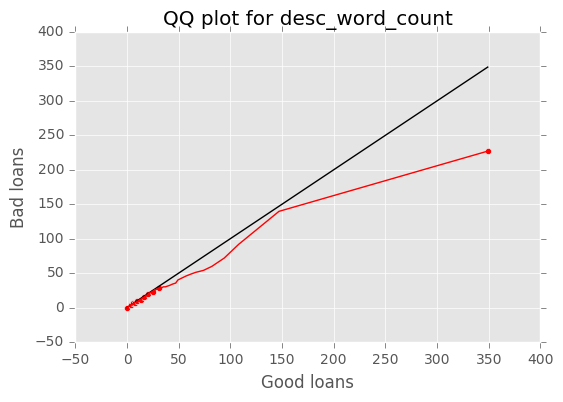

In [183]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

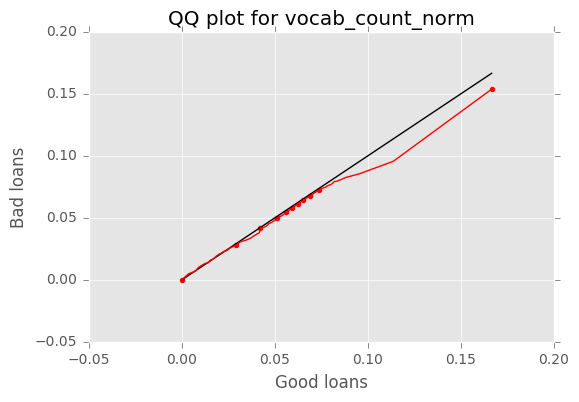

In [184]:
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

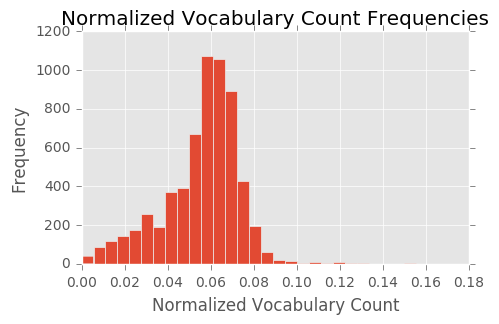

In [185]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [186]:
print desc_matrix.shape

(6241, 4770)


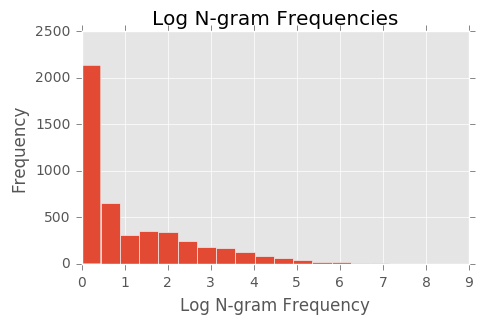

In [187]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

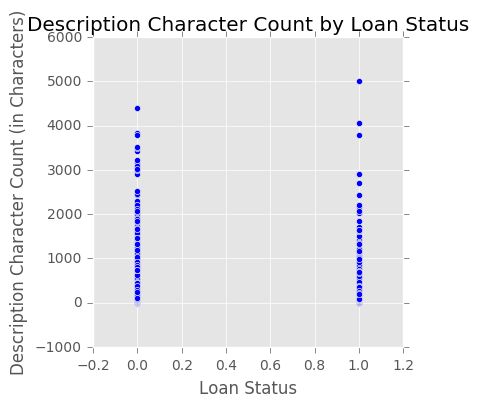

In [188]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

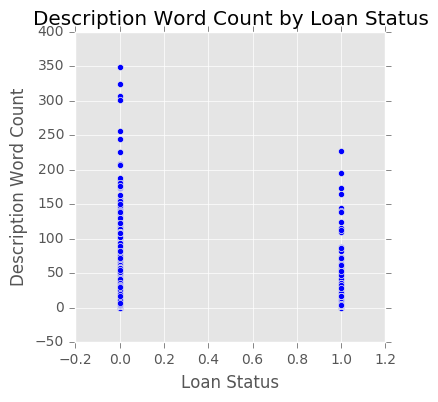

In [189]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

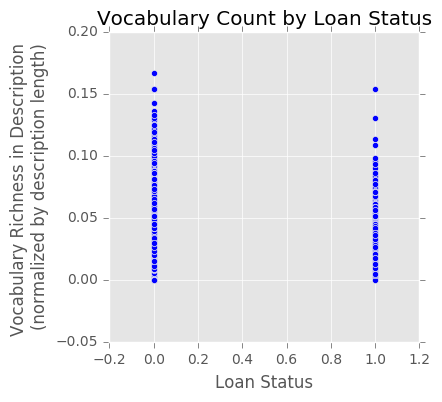

In [190]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

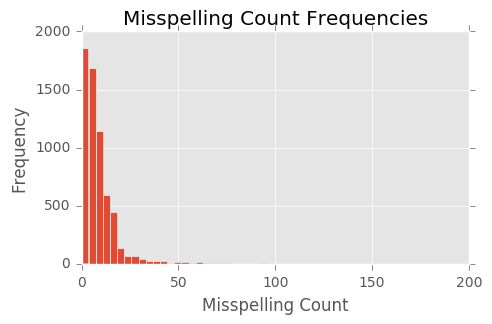

In [191]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

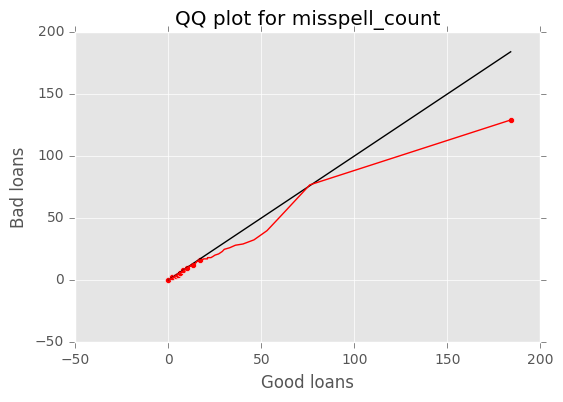

In [192]:
good_bad_quantile_plot(data_nlp, "misspell_count")

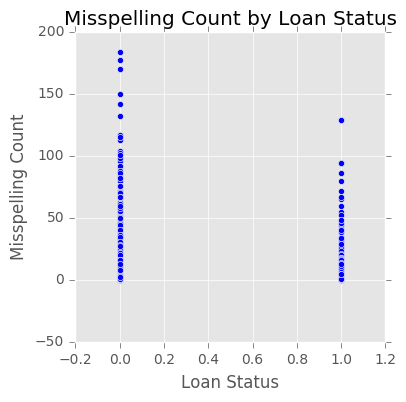

In [193]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

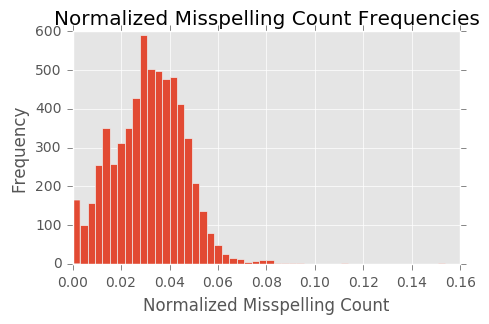

In [194]:
# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

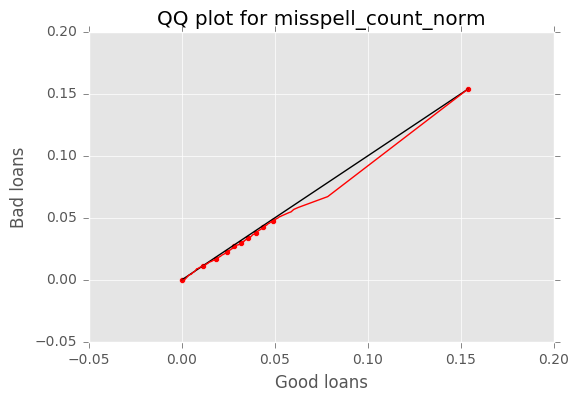

In [195]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

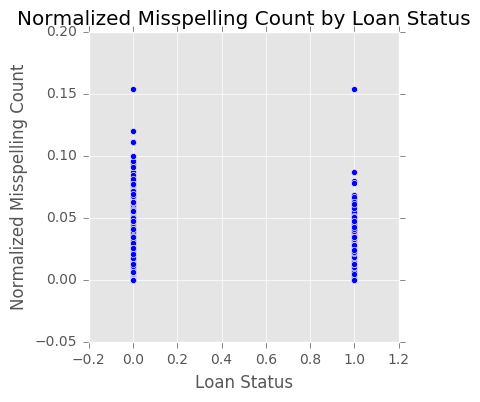

In [196]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

### Plot NLP Features

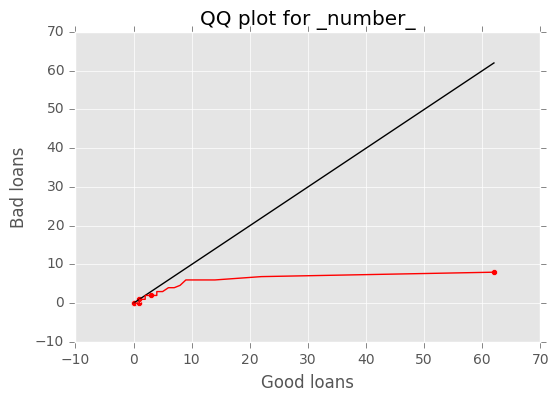

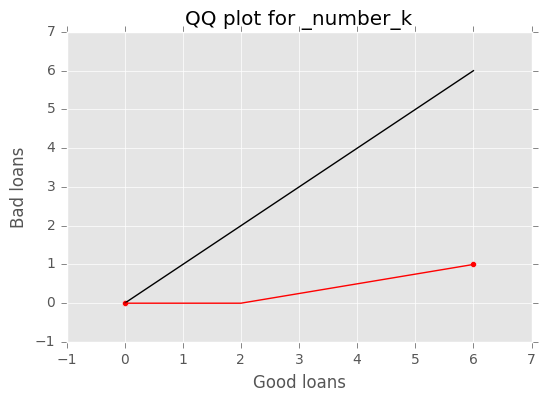

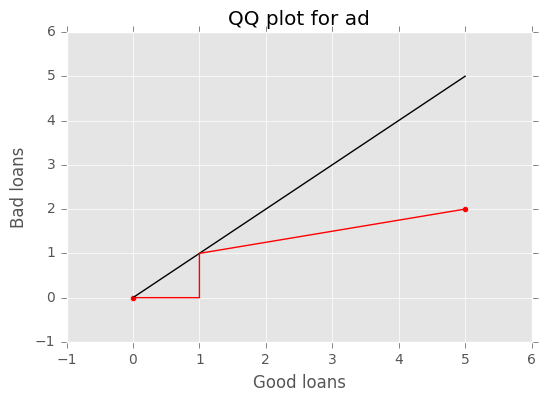

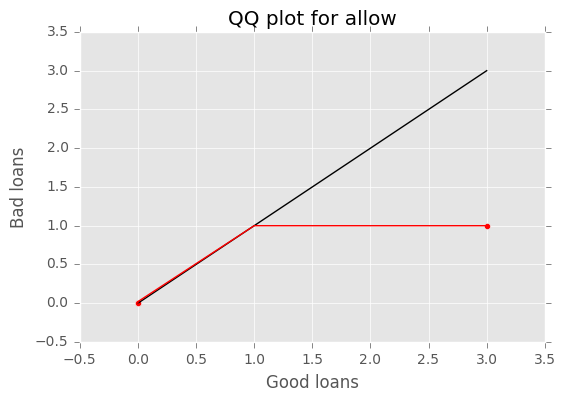

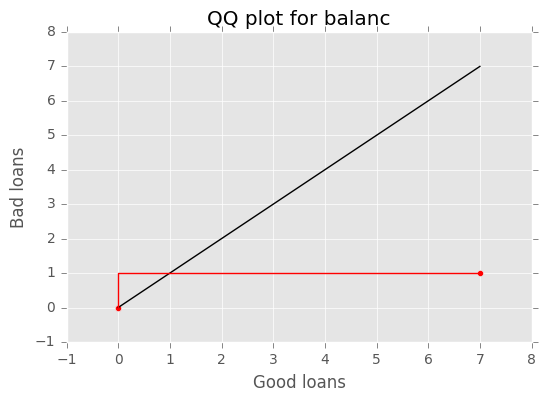

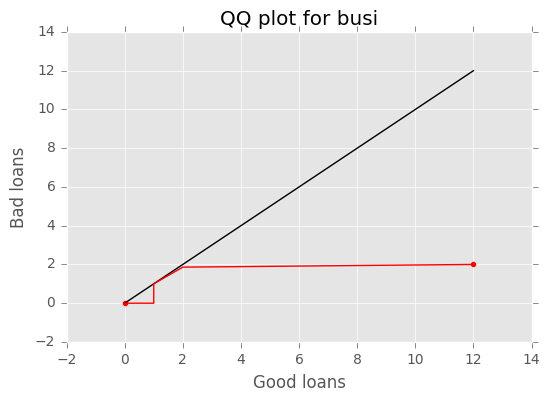

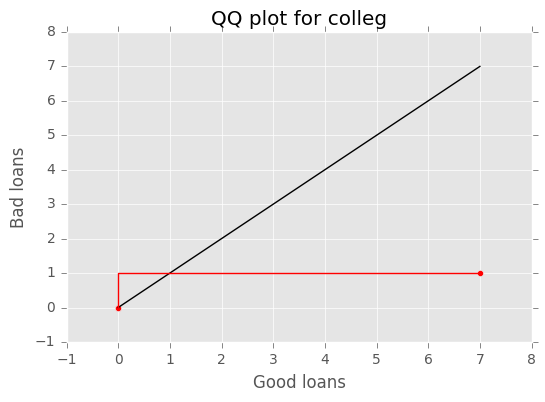

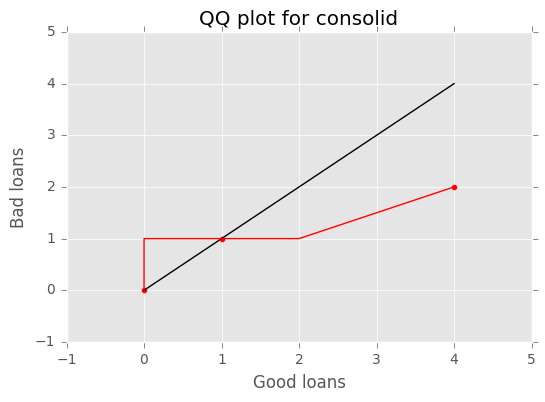

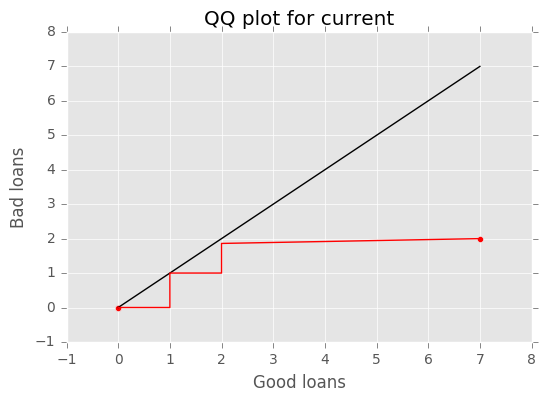

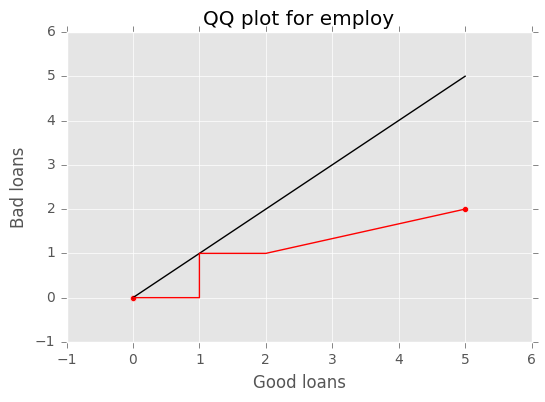

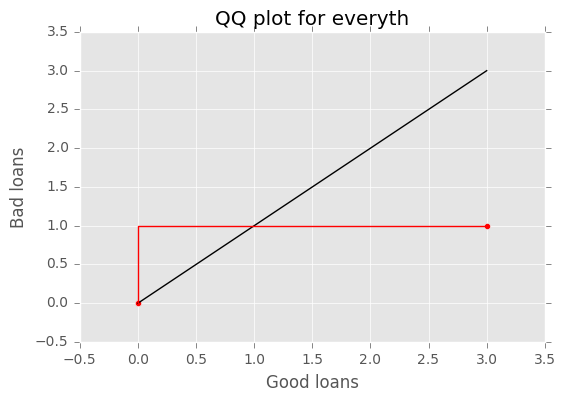

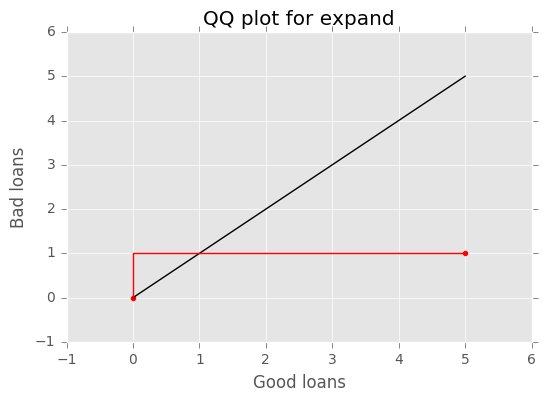

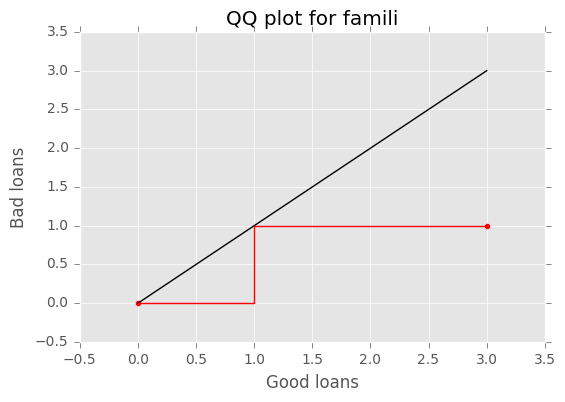

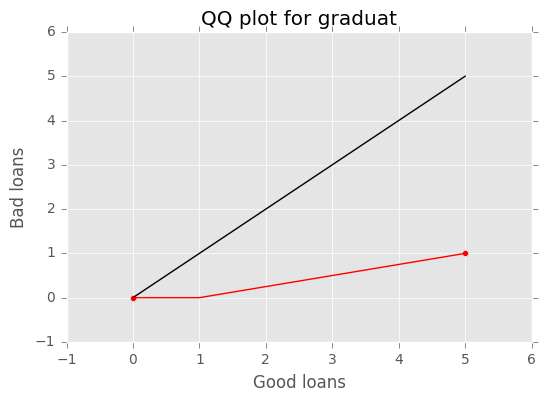

In [197]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, count_cols_bool.shape[1] / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [198]:
# function to calculate expected revenue
def expected_revenue(data):
    revenue = (data['installment'] * data['loan_term']) - data['loan_amount']
    return revenue

### Baseline Models

In [199]:
# function to compute accuracy of given model on full test set, on class 0, and on class 1
score = lambda model, x_test, y_test: \
        pd.Series([model.score(x_test, y_test), 
                    model.score(x_test[y_test == 0], y_test[y_test == 0]),
                    model.score(x_test[y_test == 1], y_test[y_test == 1])],
                    index = ['Overall Accuracy', 'Accuracy on Class 0', 'Accuracy on Class 1'])

In [200]:
# function to compute revenue of given model on full test set, on class 0, and on class 1
revenue = lambda model, x, y: \
        pd.Series([model.revenue(x, y), 
                    model.revenue(x[y == 0], y[y == 0]),
                    model.revenue(x[y == 1], y[y == 1])],
                    index = ['Overall Revenue', 'Revenue for Class 0', 'Revenue for Class 1'])

In [201]:
# model that labels everything 1
class Pos_model(object):
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [202]:
# model that labels everything 0
class Neg_model(object):
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [203]:
# model that randomly labels things
class Random_model(object):
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [204]:
### score using baseline models

pos_model = Pos_model()
pos_model_scores = score(pos_model, x, y)
pos_model_revenues = revenue(pos_model, x, y)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x, y)
neg_model_revenues = revenue(neg_model, x, y)

random_model = Random_model()
random_model_scores = score(random_model, x, y)
random_model_revenues = revenue(random_model, x, y)

In [205]:
# print scores
pd.options.display.float_format = '{:,.2f}'.format
score_df = pd.DataFrame({'Positive Model': pos_model_scores,
                         'Negative Model': neg_model_scores,
                         'Random Model': random_model_scores})
print
score_df

,Negative Model,Positive Model,Random Model
Overall Accuracy,0.82,0.18,0.50
Accuracy on Class 0,1.00,0.00,0.50
Accuracy on Class 1,0.00,1.00,0.52


In [206]:
# print revenues
pd.options.display.float_format = '{:,.0f}'.format
revenue_df = pd.DataFrame({'Positive Model': pos_model_revenues,
                         'Negative Model': neg_model_revenues,
                         'Random Model': random_model_revenues})
print
revenue_df

,Negative Model,Positive Model,Random Model
Overall Revenue,"74,358,300",0,"36,800,570"
Revenue for Class 0,"56,113,616",0,"28,093,112"
Revenue for Class 1,"18,244,685",0,"9,276,104"


### Other Models

In [207]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [208]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [209]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -4, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.0001)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = 20)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [210]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        cm_accum += confusion_matrix(y_test, y_predict)
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    f1_result = f1_accum / float(n_folds)

    # compute confusion matrix
    cm = cm_accum / float(n_folds)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Accuracy with " + model_name + ":"
    print "\tTraining:", round(train_score, 4)
    print "\tTesting:", round(test_score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [211]:
# KNN 
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

In [212]:
# logistic regression
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.5804
	Testing: 0.5704

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,625,407
1,Actual_good,130,87


F1 score =  0.240010997523


In [213]:
# logistic regression 
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8378
	Testing: 0.6898

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,813,219
1,Actual_good,169,48


F1 score =  0.193992612241


In [214]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [215]:
# LDA
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], lda)

Accuracy with LDA:
	Training: 0.1741
	Testing: 0.1737

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"1,031"
1,Actual_good,0,217


F1 score =  0.295479148055


In [216]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], qda)

Accuracy with QDA:
	Training: 0.4838
	Testing: 0.4434

Confusion Matrix:


/Users/davidmodjeska/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,0,Predicted_bad,Predicted_good
0,Actual_bad,425,607
1,Actual_good,88,129


F1 score =  0.251708880547


In [217]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6895
	Testing: 0.6107

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,701,331
1,Actual_good,155,62


F1 score =  0.193472522834


In [218]:
# SVM
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

In [219]:
# boosting
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], boost)

In [220]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.795
	Testing: 0.7805

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,962,69
1,Actual_good,205,12


F1 score =  0.0593617233279


In [221]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7614
	Testing: 0.6743

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,800,231
1,Actual_good,175,41


F1 score =  0.162290877961


### Baseline Models

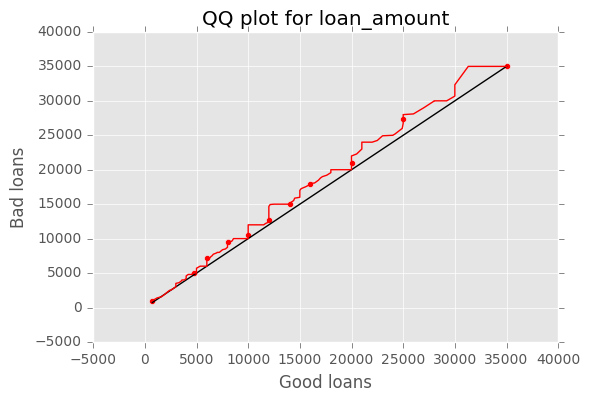

In [222]:
good_bad_quantile_plot(data, 'loan_amount')

In [223]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.2243
	Testing: 0.2243

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,201,"2,743"
1,Actual_good,38,603


F1 score =  0.302044926712


In [224]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6679
	Testing: 0.6277

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"1,999",945
1,Actual_good,389,252


F1 score =  0.272368099998


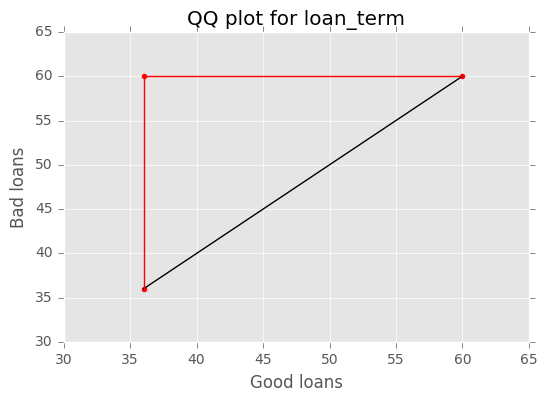

In [225]:
good_bad_quantile_plot(data, 'loan_term')

In [226]:
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.1787
	Testing: 0.1787

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"2,944"
1,Actual_good,0,641


F1 score =  0.302959771587


In [227]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7275
	Testing: 0.7275

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,379",566
1,Actual_good,411,230


F1 score =  0.319105613176


In [228]:
# SVM
# fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], svm)

In [229]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.975
	Testing: 0.8039

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,815",129
1,Actual_good,574,67


F1 score =  0.158508134246


In [230]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

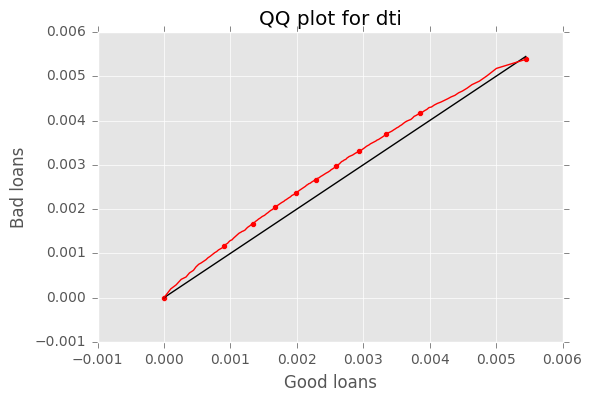

In [231]:
good_bad_quantile_plot(data, 'dti')

In [232]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8523
	Testing: 0.6991

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,354",590
1,Actual_good,489,152


F1 score =  0.219532912743


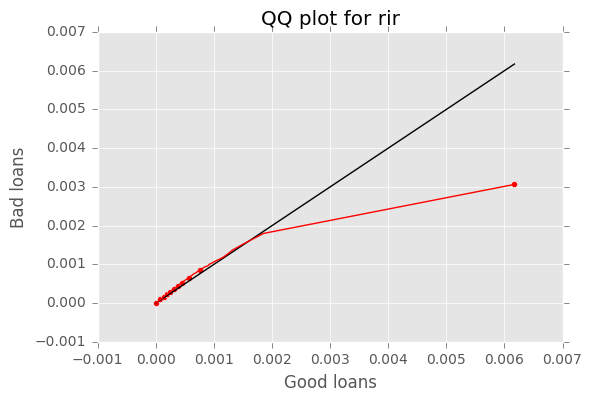

In [233]:
good_bad_quantile_plot(data, 'rir')

In [234]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8523
	Testing: 0.6991

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,354",590
1,Actual_good,489,152


F1 score =  0.219532912743


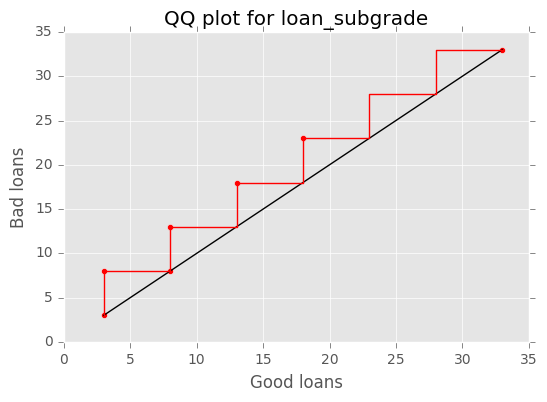

In [235]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [236]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.5555
	Testing: 0.5555

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"1,523","1,421"
1,Actual_good,173,468


F1 score =  0.369561918783


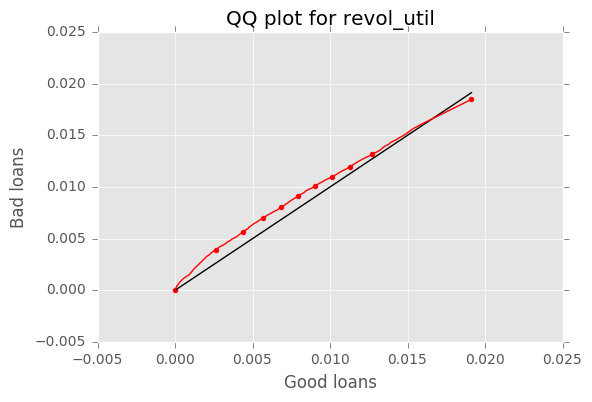

In [237]:
good_bad_quantile_plot(data, 'revol_util')

In [238]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7967
	Testing: 0.6592

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,180",764
1,Actual_good,457,183


F1 score =  0.230016197946


### Stacking

In [239]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [240]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [241]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [242]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [243]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.5072

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,539,484
1,Actual_good,130,93



F1 score with stacking by random forests = 0.2325


In [244]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6071

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,1901,1049
1,Actual_good,352,264



F1 score with stacking by random forests = 0.2737


In [245]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.7544

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,877,109
1,Actual_good,185,26



F1 score with stacking by random forests = 0.1503


In [246]:
nlp_base = np.concatenate((count_cols_bool, 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.4921

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,442,553
1,Actual_good,61,153



F1 score with stacking by logistic regression = 0.3326
